### Network traffic classification for attack detection
Possibly useful for network-based IDS or firewall

I'll focus on gradient-boosted trees rather than neural networks, as they're lighter and more suited for real-time monitoring

## Loading the data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv
/kaggle/input/unsw-nb15/UNSW-NB15_1.csv
/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv
/kaggle/input/unsw-nb15/UNSW-NB15_LIST_EVENTS.csv
/kaggle/input/unsw-nb15/UNSW-NB15_4.csv
/kaggle/input/unsw-nb15/UNSW-NB15_3.csv
/kaggle/input/unsw-nb15/UNSW-NB15_2.csv
/kaggle/input/unsw-nb15/NUSW-NB15_features.csv


In [2]:
train = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv')
test = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv')

In [3]:
feature_descriptions = pd.read_csv('/kaggle/input/unsw-nb15/NUSW-NB15_features.csv', encoding='cp1252')

In [4]:
feature_descriptions

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [6]:
train.isna().sum() 

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [7]:
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


### Making sure that there are no NaN values

In [8]:
test.isna().sum() 

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

### Checking how many unique values each of the categorical variables have

In [9]:
train["service"].nunique()

13

In [10]:
train["state"].nunique()

7

In [11]:
train["proto"].nunique()

131

In [12]:
train["attack_cat"].value_counts() # Very imbalanced

attack_cat
Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: count, dtype: int64

In [13]:
train["label"].value_counts() # Very slightly imbalanced

label
1    45332
0    37000
Name: count, dtype: int64

In [14]:
# No point in giving the model an alias for the target variable or an id of each row to memorize
cols_to_omit = ["label", "attack_cat", "id"]
input_cols = [col for col in train.columns if col not in cols_to_omit]
target_col = "label"

In [15]:
input_cols

['dur',
 'proto',
 'service',
 'state',
 'spkts',
 'dpkts',
 'sbytes',
 'dbytes',
 'rate',
 'sttl',
 'dttl',
 'sload',
 'dload',
 'sloss',
 'dloss',
 'sinpkt',
 'dinpkt',
 'sjit',
 'djit',
 'swin',
 'stcpb',
 'dtcpb',
 'dwin',
 'tcprtt',
 'synack',
 'ackdat',
 'smean',
 'dmean',
 'trans_depth',
 'response_body_len',
 'ct_srv_src',
 'ct_state_ttl',
 'ct_dst_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_flw_http_mthd',
 'ct_src_ltm',
 'ct_srv_dst',
 'is_sm_ips_ports']

### Train-valid split

In [16]:
from sklearn.model_selection import train_test_split
x = train[input_cols]
y = train[target_col]
train_x, valid_x, train_y, valid_y = train_test_split(x,y, test_size=0.2, random_state=42)

In [17]:
train_x

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
37396,1.796887,tcp,smtp,FIN,52,42,37518,3380,51.756175,31,...,2,1,1,1,0,0,0,1,3,0
45184,2.004763,tcp,-,FIN,152,26,190546,1128,88.289743,254,...,1,1,1,1,0,0,0,1,1,0
80313,0.899487,tcp,http,FIN,10,10,804,1174,21.123151,62,...,1,2,1,2,0,0,1,2,2,0
68939,0.000003,tcp,-,REQ,2,0,90,0,333333.321500,254,...,5,1,1,11,0,0,0,6,11,0
26772,0.009326,tcp,-,FIN,36,38,2334,16290,7827.579008,31,...,4,1,1,1,0,0,0,6,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.263156,tcp,http,FIN,10,8,794,2884,64.600466,62,...,1,1,1,1,0,0,1,6,1,0
54886,1.960670,tcp,http,FIN,152,34,195881,11000,94.355501,254,...,1,1,1,1,0,0,0,2,1,0
76820,0.488035,tcp,-,FIN,10,6,534,268,30.735501,254,...,1,1,1,4,0,0,0,1,4,0
860,1.211704,tcp,http,FIN,10,8,746,354,14.029829,254,...,1,1,1,1,0,0,1,1,1,0


In [18]:
feature_names = train_x.columns.to_list()

In [19]:
categorical_cols = ["state","service", "proto"]

In [20]:
for col in categorical_cols:
    train_x[col] = train_x[col].astype('category')
    valid_x[col] = valid_x[col].astype('category')

In [21]:
train_x.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
37396,1.796887,tcp,smtp,FIN,52,42,37518,3380,51.756175,31,...,2,1,1,1,0,0,0,1,3,0
45184,2.004763,tcp,-,FIN,152,26,190546,1128,88.289743,254,...,1,1,1,1,0,0,0,1,1,0
80313,0.899487,tcp,http,FIN,10,10,804,1174,21.123151,62,...,1,2,1,2,0,0,1,2,2,0
68939,0.000003,tcp,-,REQ,2,0,90,0,333333.321500,254,...,5,1,1,11,0,0,0,6,11,0
26772,0.009326,tcp,-,FIN,36,38,2334,16290,7827.579008,31,...,4,1,1,1,0,0,0,6,9,0


In [22]:
train_x.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 65865 entries, 37396 to 15795
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   dur                65865 non-null  float64 
 1   proto              65865 non-null  category
 2   service            65865 non-null  category
 3   state              65865 non-null  category
 4   spkts              65865 non-null  int64   
 5   dpkts              65865 non-null  int64   
 6   sbytes             65865 non-null  int64   
 7   dbytes             65865 non-null  int64   
 8   rate               65865 non-null  float64 
 9   sttl               65865 non-null  int64   
 10  dttl               65865 non-null  int64   
 11  sload              65865 non-null  float64 
 12  dload              65865 non-null  float64 
 13  sloss              65865 non-null  int64   
 14  dloss              65865 non-null  int64   
 15  sinpkt             65865 non-null  float64 
 16  dinpk

### Training the LightGBM model

In [23]:
import lightgbm as lgb

fit_params={
        "objective": "binary",
        "metric": "auc",
        "seed":42
}

dtrain = lgb.Dataset(train_x, label=train_y, categorical_feature=categorical_cols, feature_name=feature_names)
dvalid = lgb.Dataset(valid_x, label=valid_y, categorical_feature=categorical_cols, feature_name=feature_names)

model = lgb.train(
    params={
        "objective": "binary",
        "metric": "auc",
    },
    train_set=dtrain,
    valid_sets=[dvalid],
    num_boost_round=300,
    callbacks=[
        lgb.early_stopping(stopping_rounds=3),
    ]
)

[LightGBM] [Info] Number of positive: 36283, number of negative: 29582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5949
[LightGBM] [Info] Number of data points in the train set: 65865, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550869 -> initscore=0.204183
[LightGBM] [Info] Start training from score 0.204183
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[137]	valid_0's auc: 0.997954


### Evaluating the model on the test dataset

In [24]:
test_y = test[target_col]
test_x = test[input_cols]
for col in categorical_cols:
    test_x[col] = test_x[col].astype('category')

/tmp/ipykernel_13/1877209788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x[col] = test_x[col].astype('category')
/tmp/ipykernel_13/1877209788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x[col] = test_x[col].astype('category')
/tmp/ipykernel_13/1877209788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [25]:
test_x.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 42 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   dur                175341 non-null  float64 
 1   proto              175341 non-null  category
 2   service            175341 non-null  category
 3   state              175341 non-null  category
 4   spkts              175341 non-null  int64   
 5   dpkts              175341 non-null  int64   
 6   sbytes             175341 non-null  int64   
 7   dbytes             175341 non-null  int64   
 8   rate               175341 non-null  float64 
 9   sttl               175341 non-null  int64   
 10  dttl               175341 non-null  int64   
 11  sload              175341 non-null  float64 
 12  dload              175341 non-null  float64 
 13  sloss              175341 non-null  int64   
 14  dloss              175341 non-null  int64   
 15  sinpkt             175341 non-null

In [26]:
test_y_pred = model.predict(test_x)

In [27]:
test_y_pred

array([0.98816138, 0.99789045, 0.99828936, ..., 0.9995114 , 0.99988825,
       0.99988825])

In [28]:
preds_rounded = [round(x) for x in test_y_pred]

In [29]:
from collections import Counter
Counter(preds_rounded)

Counter({1: 104095, 0: 71246})

In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, preds_rounded)

0.8994074403590717

Overall accuracy of the model is ~90%

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(test_y, preds_rounded)

array([[ 54804,   1196],
       [ 16442, 102899]])

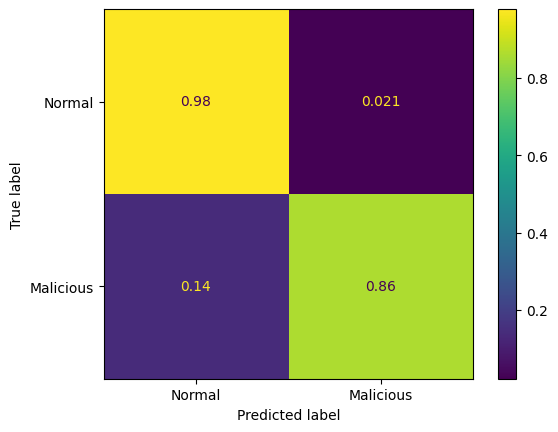

In [32]:
cm = confusion_matrix(test_y, preds_rounded, labels=[0,1],normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Normal", "Malicious"],)

disp.plot()

From this confusion matrix we can tell that with the default 50% threshold of prediction:

* 14% of malicious traffic is misclassified as normal
* 2.1% of normal traffic is misclassified as malicious

As always, we can try to trade-off precisio and recall to get a balance that is better suited to whatever use case we may have in mind:

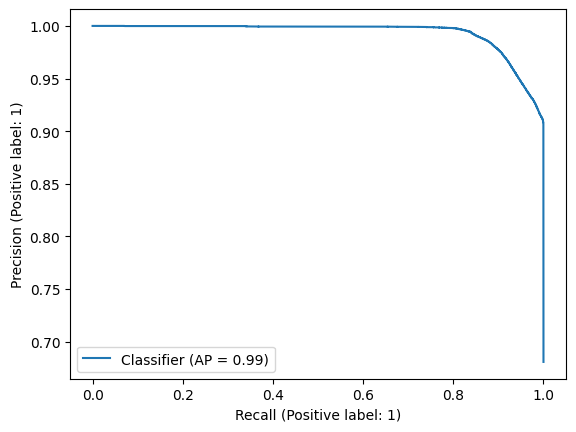

In [33]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(test_y, test_y_pred)

In [34]:
from sklearn.metrics import average_precision_score

average_precision_score(test_y, test_y_pred)

0.9932777462541124

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

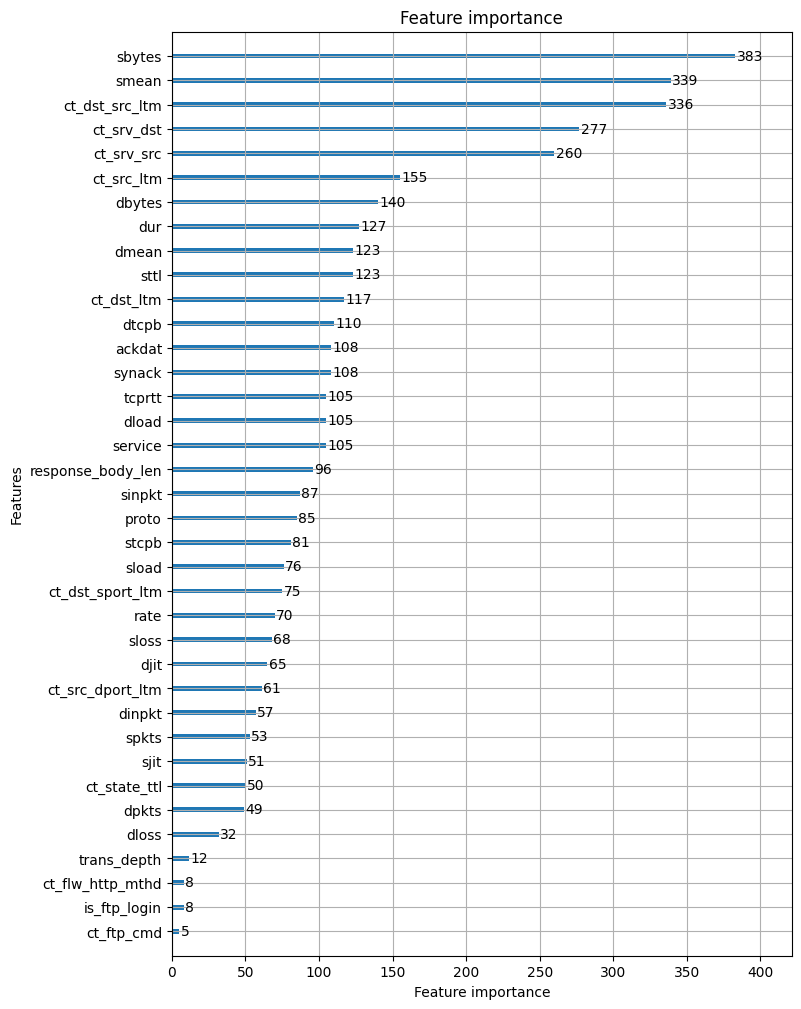

In [35]:
lgb.plot_importance(model, figsize=(8,12))

It appears that the following variables are most important for classification in this model:

* `sbytes` - number of bytes sent from the source to the destination during the transaction
* `smean` - mean size of the sent packets
* `ct_dst_src_ltm` - No of connections of the same source (1) and the destination (3) address in in 100 connections
* `ct_srv_dst` - No. of connections that contain the same service (14) and destination address (3) in 100 connections
* `ct_srv_src` - No. of connections that contain the same service (14) and source address (1) in 100 connections 

In [36]:
def get_feature_description(feature_name: str)->str:
    return feature_descriptions[feature_descriptions['Name'].str.contains(feature_name)]["Description"].item()

In [37]:
get_feature_description("sbytes")

'Source to destination transaction bytes '

In [38]:
get_feature_description("smean")

'Mean of the ?ow packet size transmitted by the src '

In [39]:
get_feature_description("ct_dst_src_ltm")

'No of connections of the same source (1) and the destination (3) address in in 100 connections according to the last time (26).'

In [40]:
get_feature_description("ct_srv_dst")

'No. of connections that contain the same service (14) and destination address (3) in 100 connections according to the last time (26).'

In [41]:
get_feature_description("ct_srv_src")

'No. of connections that contain the same service (14) and source address (1) in 100 connections according to the last time (26).'

### Let us also check the feature importance using SHAP

In [42]:
!pip install shap -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.1 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.7
    Uninstalling slicer-0.0.7:
      Successfully uninstalled slicer-0.0.7
  Attempting uninstall: shap
    Found existing installation: shap 0.44.1
    Uninstalling shap-0.44.1:
      Successfully uninstalled shap-0.44.1


In [43]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(test_x)

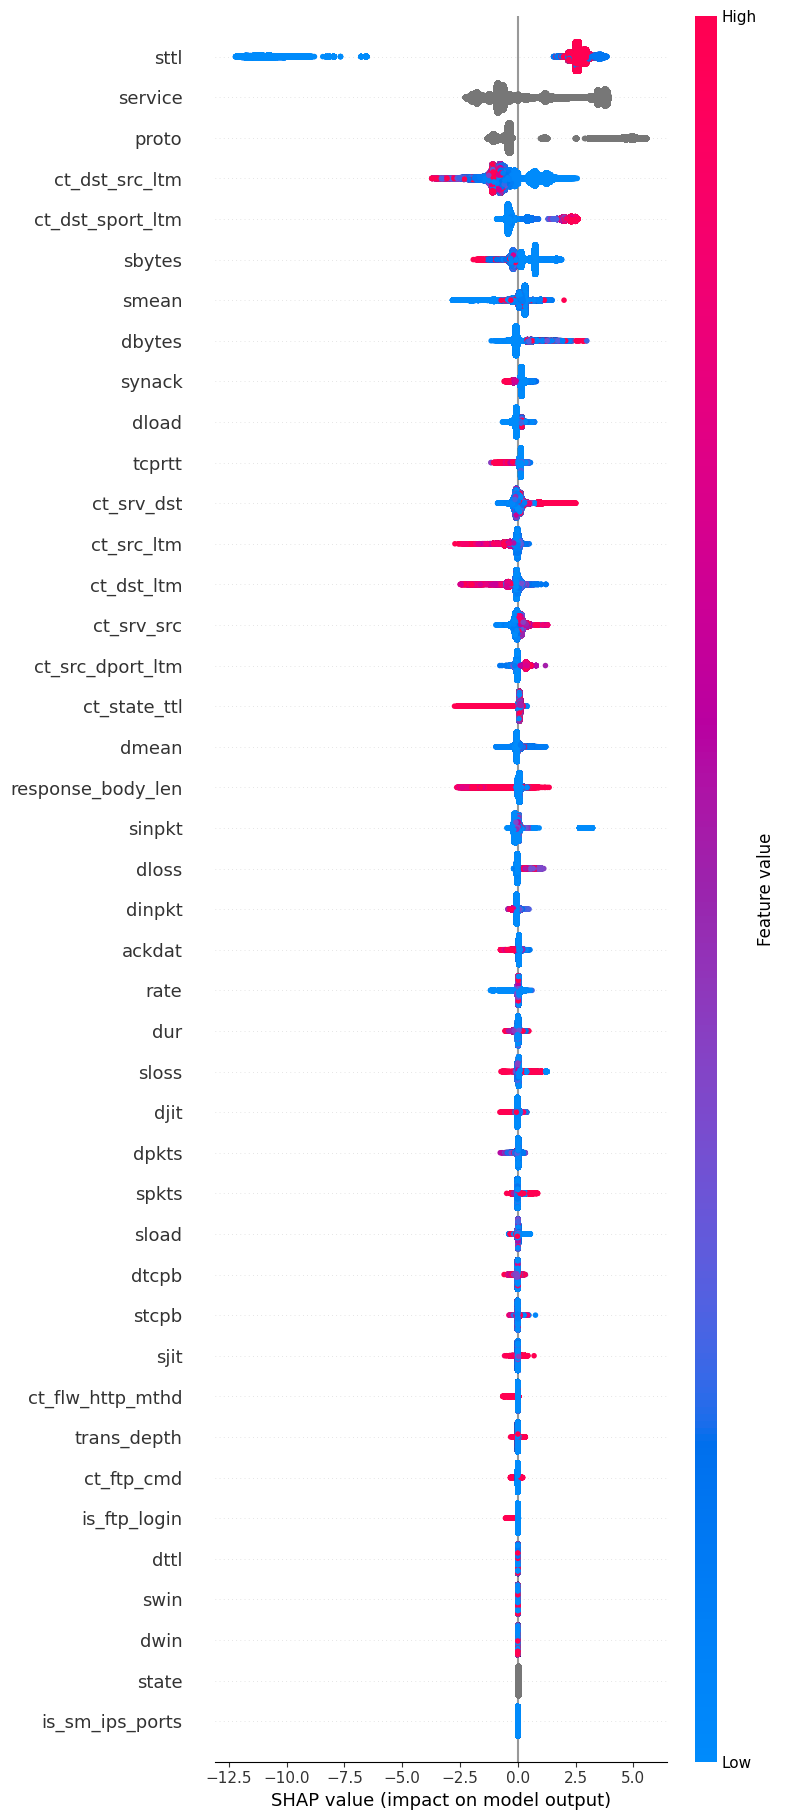

In [44]:
shap.summary_plot(shap_values, test_x, max_display=test_x.shape[1])

In [45]:
get_feature_description("ct_dst_sport_ltm")

'No of connections of the same destination address (3) and the source port (2) in 100 connections according to the last time (26).'

In [46]:
get_feature_description("ct_dst_src_ltm")

'No of connections of the same source (1) and the destination (3) address in in 100 connections according to the last time (26).'

Here we see that `sttl` (Source to destination time to live) and the service/protocol being utilized appear to be more important. In general, the game-theoretic approach for model interpretation used by SHAP is usually considered more reliable than the split count used by LightGBM's built-in importance plot.

It's interesting that high TTL appears to correlate with traffic being categorized as malicious.

If the same source and destination address have been used frequently before, then it's classified more often as normal traffic.



Let's take a look at a couple examples to see how they are categorized by the model, and why:

True label: 0
Attack type (if not normal traffic): Normal
Model prediction: [0.99789045]


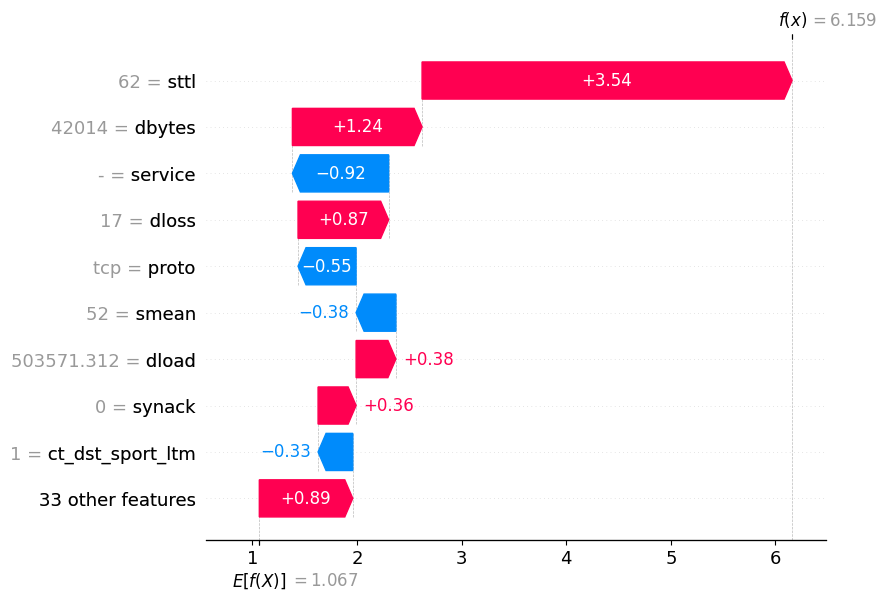

In [47]:
def explain_prediction(row_id : int):
    print(f"True label: {test_y[row_id]}")
    print(f'Attack type (if not normal traffic): {test.iloc[[row_id]]["attack_cat"].item()}')
    print(f"Model prediction: {model.predict(test_x.iloc[[row_id]])}")
    shap.plots.waterfall(shap_values[row_id])

explain_prediction(1)

The first ~half of the test dataset rows are examples of normal (non-attack) traffic

True label: 0
Attack type (if not normal traffic): Normal
Model prediction: [0.99805778]


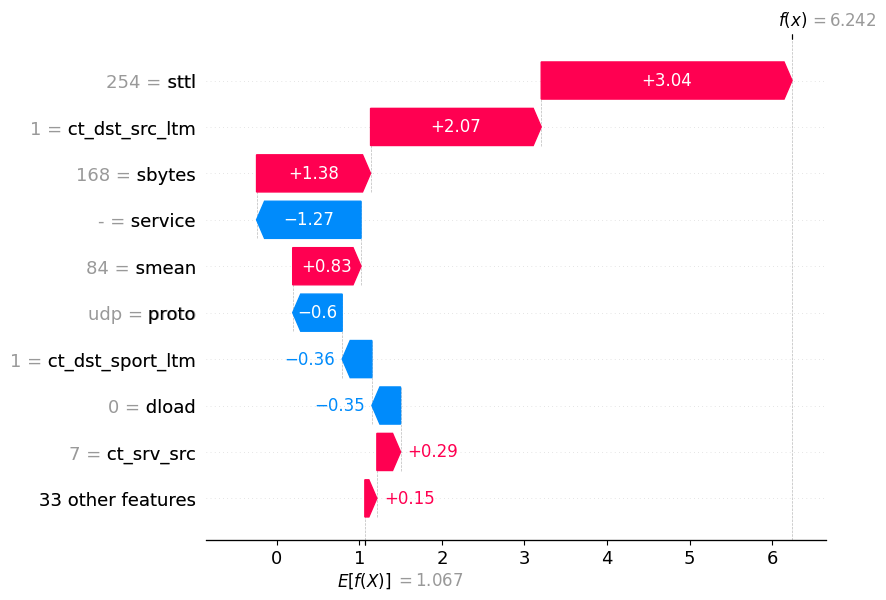

In [48]:
explain_prediction(42)

True label: 0
Attack type (if not normal traffic): Normal
Model prediction: [0.15417711]


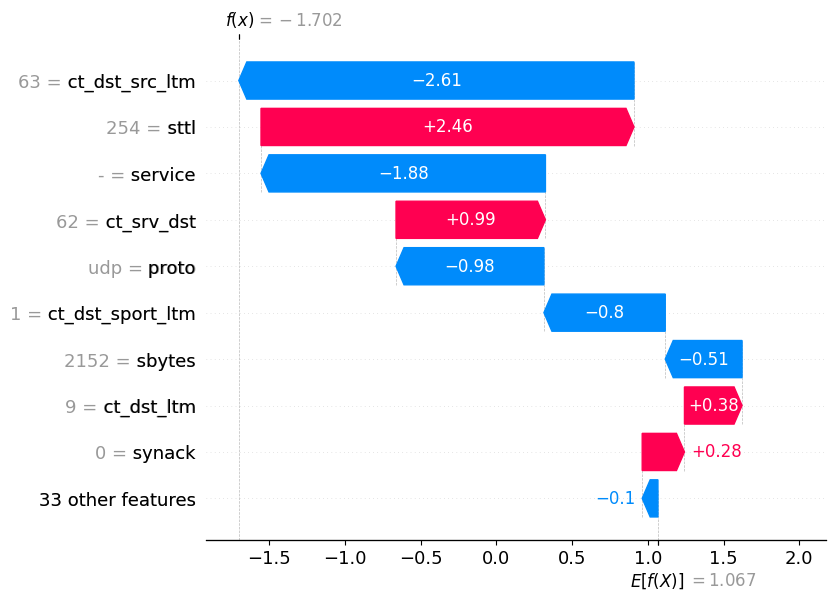

In [49]:
explain_prediction(120)

True label: 0
Attack type (if not normal traffic): Normal
Model prediction: [9.48396405e-05]


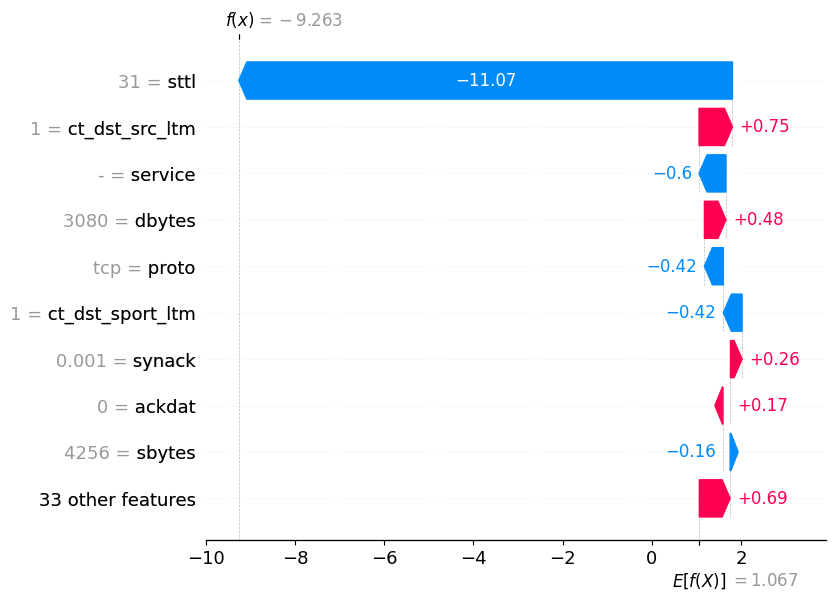

In [50]:
explain_prediction(256)

True label: 1
Attack type (if not normal traffic): Exploits
Model prediction: [0.99983214]


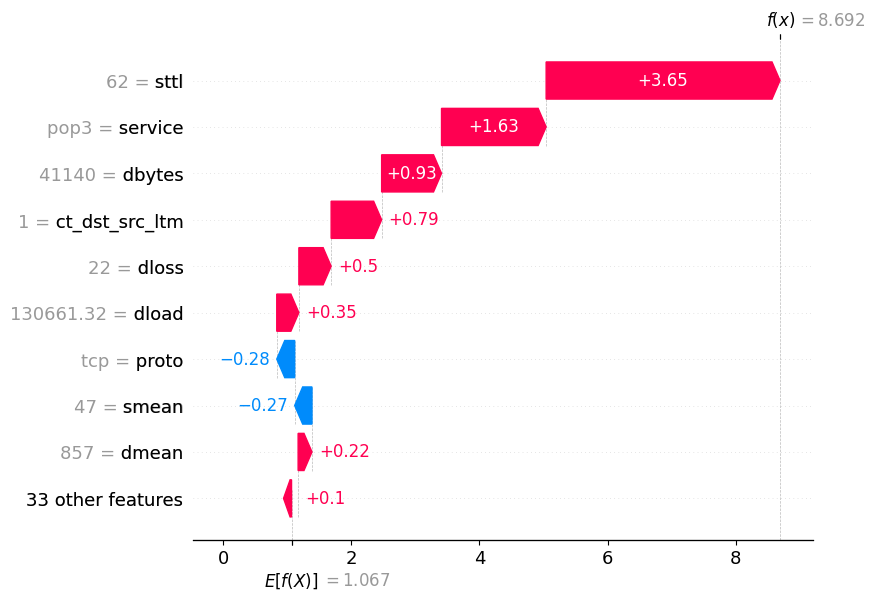

In [51]:
explain_prediction(100_000)

True label: 1
Attack type (if not normal traffic): Exploits
Model prediction: [0.99929312]


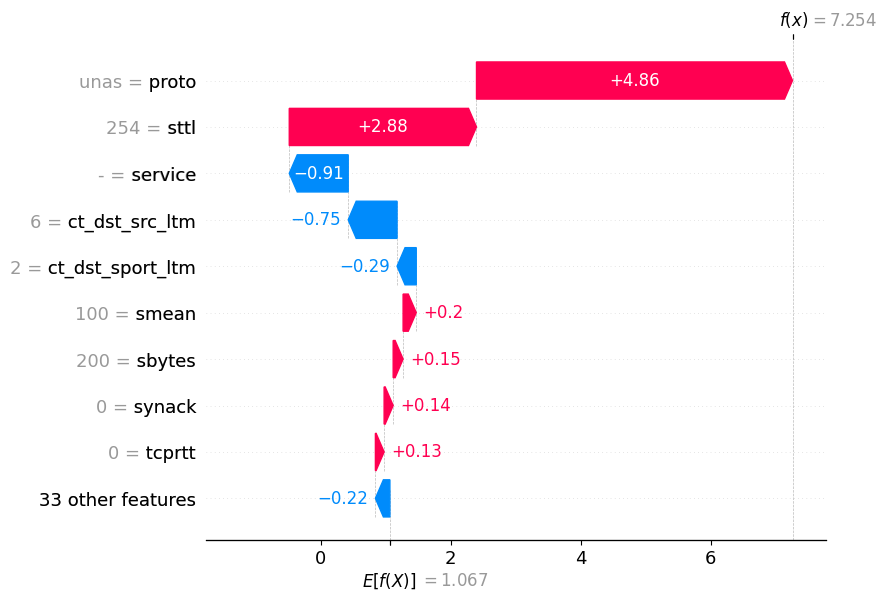

In [52]:
explain_prediction(120_000)

True label: 1
Attack type (if not normal traffic): DoS
Model prediction: [0.99895704]


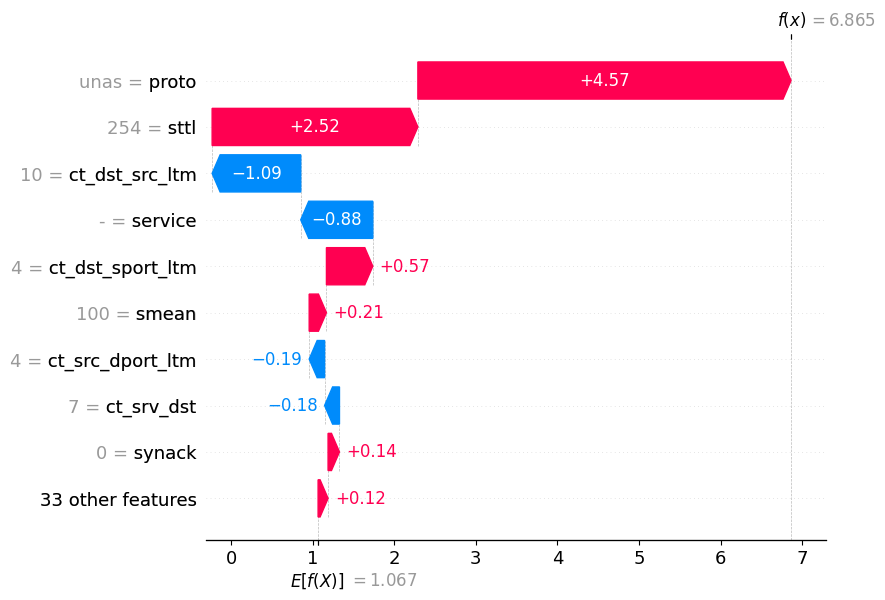

In [53]:
explain_prediction(85_000)

Overall, it appears that the model's decisions are dominated by a combination of the TTL of the packets being sent, alongside the protocol and service being utilized.